# A Simple Model (Interactive)

*Note: this notebook requires Microsoft Excel in order to run interactively and must therefore be run locally on a Mac or Windows machine. <u>It does not work remotely on the IPython notebook server.</u>* 

Once you've installed everything, you should be able to use this notebook by changing to the directory/folder containing this `SimpleModelDemo-interactive.ipynb` in in the command line. Then enter the command: `jupyter notebook`, which will automatically start a local IPython notebook server on your machine and launch your web browser.

This notebook demonstrates various implementations of a simple model to be used in [Rhodium](https://github.com/Project-Platypus/Rhodium/), a Robust Decision Making (RDM) framework. Different implementations of the same model are described in an attempt to cover a number of observed  use cases. These include models defined within the Excel workbook itself; third-party models implemented in other languages such as R, C, C++, and Fortran; and models written in Python.

In all cases, the initial parameters will be read from an Excel file; however, the same principle applies to a number of other file formats such as CSV, JSON, etc.

## Setting Things Up
Python makes it easy to import external libraries, called "packages", using the `import` command. Any packages that aren't included with Python can be installed using the `pip` package manager. Just type `pip install <package_name>` in the command line to install. Let's begin by importing some Python packages we'll be using.

In [1]:
from rhodium import *
import numpy as np
import pandas as pd
import xlwings as xw
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

Before we can use a model we need to define it along with its parameters. The model can be 

1. implemented internally, as a Python function, with Python variables as parameters, 
2. imported from external source codes and libraries,
3. defined by formulas in an Excel workbook

In this notebook, we'll begin with the latter Excel-based model and read in the parameters from the same file. Parameters can also be read from data files in a number of different formats including Excel, CSV, JSON, etc.

We'll use the [xlwings](https://www.xlwings.org/) package to open the `SimpleModel.xlsx` file. This workbook contains all our model parameters including the model itself. Xlwings provides realtime interaction with the Microsoft Excel application to read and write from cells or ranges of cells. For instance, any changes made to cells referenced in formulas will automatically cause the formulas to update their cell values. 

An example of the input and output worksheets are displayed below. In addition to the parameter values and labels, the inputs have a range of specificed values described by the `Low` and `High` column headers. These can be used to define uncertainty ranges or policy levers in Rhodium. The input and output values have been highlighted.

| ![Inputs](images/input_sheet.png "Inputs") | ![Outputs](images/output_sheet.png "Outputs") |                        
|:------------------------------------------:|:---------------------------------------------:|
| INPUTS                                     | OUTPUTS                                       |

Throughout this notebook, we'll use a simple model that receives a set of ten input parameters (labeled `Var1`, `Var2`, ..., `Var10`) and multiplies and adds somewhat arbitrary values to generate the five output values (labeled `Output1`, `Outputs2`,...`Output5`). The model and its formulas are defined in the `Model` sheet below.

| ![Model](images/model_sheet_formulas.png "Model") |
|:-------------------------------------------------:|
| MODEL                                             |

---
### Reading an Excel File
Let's read the model data from the Excel file. We'll then re-implement the Excel model in R and then in Python to illustrate how to use different models with Rhodium.

In [2]:
# Connect to existing Excel workbook
wb = xw.Book('SimpleModel.xlsx')
database_sheet = wb.sheets['DATABASE']   # currently empty, but will eventually store optimization results
output_sheet   = wb.sheets['OUTPUTS']    # aggregates model outputs
model_sheet    = wb.sheets['MODEL']      # defines the model
input_sheet    = wb.sheets['INPUTS']     # contains input data

# input data
input_labels = input_sheet.range('A2').expand('down').value
input_values = input_sheet.range('B2:B11').value 
input_mins   = input_sheet.range('C2:C11').value
input_maxs   = input_sheet.range('D2:D11').value

# output data
output_labels = output_sheet.range('A2:A6').expand('down').value
output_values = output_sheet.range('B2:B6').value

In [3]:
print 'Input Labels: ' + '\t'.join(input_labels)
print 'Input Values: ' + '\t'.join(map(str, input_values))

Input Labels: Var1	Var2	Var3	Var4	Var5	Var6	Var7	Var8	Var9	Var10
Input Values: 5.0	2.0	5.0	2.0	5.0	2.0	5.0	2.0	5.0	2.0


Now we can begin using the model data to perform RDM analyses.

---
## Case #1: Driving Excel Models
In the first scenario, we have a model implemented entirely in a Microsoft Excel workbook. In our case, this is the same one we're currently reading from. A simple Python wrapper function drives the model by changing the input cells and fetching the re-calculated output cells. This is the same principle behind manually entering new input values and recording their outputs as the forumlas update.

**Note that this approach has a significant computational overhead since it must interact with an external application for each model evaluation. It should be used with lightweight models of proofs of concept.**

### Constructing the Model
Rhodium needs a function to drive the model. Here we write different values to the worksheet and read the cells corresponding to the outputs.

In [4]:
def simple_model_xl(Var1, Var2, Var3, Var4, Var5, Var6, Var7, Var8, Var9, Var10):
    
    # update inputs
    input_sheet.range('B2:B11').options(transpose=True).value = \
        [Var1, Var2, Var3, Var4, Var5, Var6, Var7, Var8, Var9, Var10]
    
    # record outputs
    output = output_sheet.range('B2:B6').value
    
    return output

### Setting up Rhodium
We need to pass the function that evaluates the model into Rhodium and specify the parameters, their types, and their expected values and/or ranges. 

In [5]:
model_xl = Model(simple_model_xl)

model_xl.parameters = [
    Parameter( input_labels[0] ), # Var1...
    Parameter( input_labels[1] ),
    Parameter( input_labels[2] ),
    Parameter( input_labels[3] ),
    Parameter( input_labels[4] ),
    Parameter( input_labels[5] ),
    Parameter( input_labels[6] ),
    Parameter( input_labels[7] ),
    Parameter( input_labels[8] ),
    Parameter( input_labels[9] )
] 

model_xl.levers = [
    IntegerLever( input_labels[0], input_mins[0], input_maxs[0] ), # Var1, Low, High...   
    IntegerLever( input_labels[1], input_mins[1], input_maxs[1] ),   
    IntegerLever( input_labels[2], input_mins[2], input_maxs[2] ),  
    IntegerLever( input_labels[3], input_mins[3], input_maxs[3] ), 
    IntegerLever( input_labels[4], input_mins[4], input_maxs[4] ),
    IntegerLever( input_labels[5], input_mins[5], input_maxs[5] ),
    IntegerLever( input_labels[6], input_mins[6], input_maxs[6] ),
    IntegerLever( input_labels[7], input_mins[7], input_maxs[7] ),
    IntegerLever( input_labels[8], input_mins[8], input_maxs[8] ),
    IntegerLever( input_labels[9], input_mins[9], input_maxs[9] )
]

model_xl.responses = [
    Response( output_labels[0], Response.MAXIMIZE ), # Output1...
    Response( output_labels[1], Response.MINIMIZE ),
    Response( output_labels[2], Response.MAXIMIZE ),
    Response( output_labels[3], Response.MINIMIZE ),
    Response( output_labels[4], Response.MAXIMIZE )
]

# # alternate way to define model parameters
# # note: levers and responses result in type error (more work needed)
# for i, input in enumerate(input_labels):
#     foo = IntegerLever( input_labels[i], input_mins[i], input_maxs[i] )
#     model.parameters += Parameter( input_labels[i] )
#     model.levers += RealLever( input_labels[i], input_mins[i], input_maxs[i] )

# for i, output in enumerate(output_labels):
#     model.responses += Response( output_labels[i], Response.MAXIMIZE )


In the code above, we're defining the inputs as integer-valued levers. Rhodium gives us various options to choose from including real and categorical values.

Notice that outputs ("responses" in Rhodium speak) now include an extra bit of code, e.g. `Response.MAXIMIZE`. These tell Rhodium how to use the outputs during the optimization. Using `Response.MAXIMIZE` tells Rhodium to maximize that output value. Similarly, `Response.MINIMIZE` minimizes that output. In addition, using `Response.INFO` or `Response.IGNORE` tells Rhodium to disregard that output during optimization. This may be useful, for instance, if we only want to use that output for visualization. 

*<u>Note: The order in which the optimized responses are defined matters.</u>*

### Multi-Objective Optimization
We can now generate alternative designs by varying the input values within their specified limits. We can find Pareto-approximate solutions using the NSGA-II multi-objective oprimization algorithm.

This is among the most time-consuming parts of the analysis so let's make a note of how long it takes to run.

In [6]:
start_time = time.time()
output_xl = optimize(model_xl, 'NSGAII', 500)
runtime_xl = time.time() - start_time
print 'Runtime {:0.1f}s'.format(runtime_xl)

Runtime 14.9s


The optimization outputs are stored in an internal Rhodium data format; however, it can be easily converted to other formats including CSV, JSON, or [Pandas](http://pandas.pydata.org/). The Pandas `DataFrame` is a data structure inspired by R and provides powerful data analysis and manipulation tools that are optimized for tablar data. It's also a common data structure used in high-performance computing. So let's use it!

In [7]:
# convert output into Pandas DataFrame
df = output_xl.as_dataframe()
df

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Output1,Output2,Output3,Output4,Output5
0,5,5,7,8,5,5,9,10,1,5,7.951788,12.682060,9.878696,0.365607,3.584934
1,8,7,7,9,1,4,3,1,1,7,10.464889,9.622741,1.006137,0.365607,5.018907
2,7,9,10,9,10,4,5,4,1,4,12.708650,18.343136,3.963657,0.365607,2.867947
3,9,6,3,1,1,1,5,3,4,5,8.614839,1.986283,2.983616,1.462428,3.584934
4,4,9,8,2,5,10,1,10,6,1,10.982971,7.683118,9.809106,2.193643,0.716987
5,2,3,2,1,7,6,5,9,8,10,3.646128,8.302225,8.863860,2.924857,7.169868
6,6,9,8,1,8,6,10,8,10,3,11.655408,9.271158,7.927314,3.656071,2.150960
7,10,10,9,8,8,9,8,2,7,6,14.111018,15.990735,2.029672,2.559250,4.301921
8,9,10,2,6,2,4,10,10,3,3,11.265217,7.841030,9.887395,1.096821,2.150960
9,9,9,3,8,2,2,1,10,3,10,10.871506,9.473854,9.809106,1.096821,7.169868


We can just as easily export the data into the same Excel workbook we've been using thus far. Recall that the variable `database_sheet`, which we created earlier, contains our connection to the `DATABASE` worksheet. We can then write all the output data stored in the Pandas `DataFrame` directly to the worksheet.

In [8]:
# save output Excel worksheet
database_sheet.range('A1').value = df

## Visualization
Here are a few ways to visualize the optimization results.

In [9]:
# set display preferences
sns.set()
sns.set_style('darkgrid')

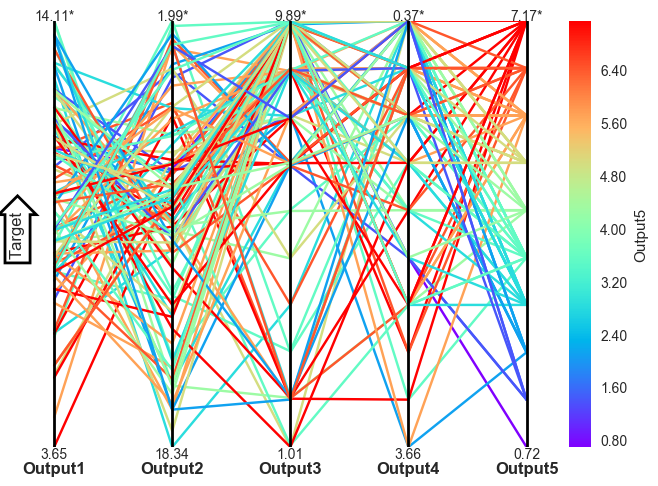

In [10]:
parallel_coordinates(model_xl, output_xl, colormap='rainbow', target='top')
plt.show()

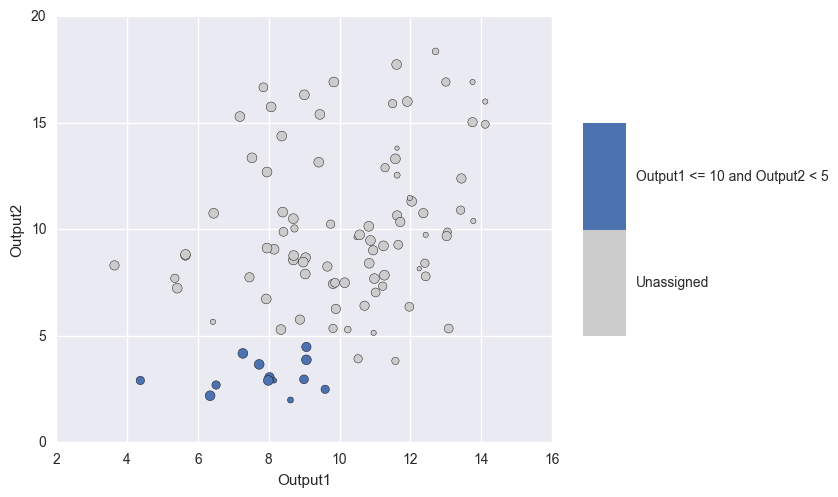

In [11]:
scatter2d(model_xl, output_xl, brush="Output1 <= 10 and Output2 < 5")
plt.show()

Create Artists


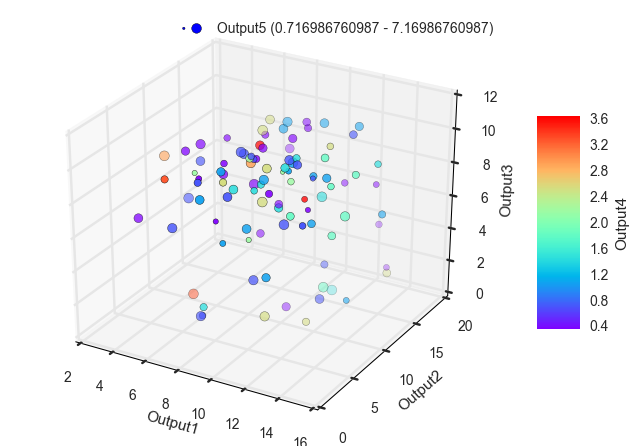

In [12]:
scatter3d(model_xl, output_xl, s="Output5", show_legend=True)
plt.show()

---
## Case #2: External Model
In many cases the models will be defined in another language such as C, C++, R, or Fortran. 

For models written in R, Rhodium can translate the code directly into Python by using its "R Bridge" module. This requires a package called `pyper`. If you haven't installed this already typing `pip install pyper` on the command line should take care of it for you.

For models in compiled languages such as C/C++ and Fortran, Rhodium's so-called "Native Function" support enables us to tap into the shared libraries generated during compilation. These libraries enable Rhodium to run specific functions in languages as if it were in natively in that environment - hence the term.

In UNIX/Linux operating systems, these are files with `*.so` extensions. In Windows systems they're called dynamic link libraries and carry a `*.dll` extension. 

### R Models
*<u>Note: If you're running this notebook on your local machine, this section assumes you have already installed R.</u>*

To best serve this somewhat contrived example, we'll have to reverse engineer the model defined in the Excel workbook. We'll create a separate R script with a function that takes the expected inputs, performs the calculations, and returns the outputs. Functionally, it will be identical to our the model defined internally in the Excel workbook. This R script has been implemented in the file [simple_model.r](./simple_model.r), which we'll use throughout the remainder of this section. 

First, let's import this R Bridge from Rhodium.

In [13]:
from rhodium.rbridge import RModel

We need to tell Rhodium to look in the R file `simple_model.R` and use the `simple_model` function as our model.

In [14]:
model_r = RModel('simple_model.R', 'simple_model')

# the rest should look familiar by now...

model_r.parameters = [
    Parameter( input_labels[0] ),
    Parameter( input_labels[1] ),
    Parameter( input_labels[2] ),
    Parameter( input_labels[3] ),
    Parameter( input_labels[4] ),
    Parameter( input_labels[5] ),
    Parameter( input_labels[6] ),
    Parameter( input_labels[7] ),
    Parameter( input_labels[8] ),
    Parameter( input_labels[9] )
] 

model_r.levers = [
    IntegerLever( input_labels[0], input_mins[0], input_maxs[0] ),    
    IntegerLever( input_labels[1], input_mins[1], input_maxs[1] ),   
    IntegerLever( input_labels[2], input_mins[2], input_maxs[2] ),  
    IntegerLever( input_labels[3], input_mins[3], input_maxs[3] ), 
    IntegerLever( input_labels[4], input_mins[4], input_maxs[4] ),
    IntegerLever( input_labels[5], input_mins[5], input_maxs[5] ),
    IntegerLever( input_labels[6], input_mins[6], input_maxs[6] ),
    IntegerLever( input_labels[7], input_mins[7], input_maxs[7] ),
    IntegerLever( input_labels[8], input_mins[8], input_maxs[8] ),
    IntegerLever( input_labels[9], input_mins[9], input_maxs[9] )
]

model_r.responses = [
    Response( output_labels[0], Response.MAXIMIZE ),
    Response( output_labels[1], Response.MINIMIZE ),
    Response( output_labels[2], Response.MAXIMIZE ),
    Response( output_labels[3], Response.MINIMIZE ),
    Response( output_labels[4], Response.MAXIMIZE )
]

### Multi-Objective Optimization
We'll run the optimization again and take note of the runtime.

In [15]:
start_time = time.time()
output_r = optimize(model_r, 'NSGAII', 500)
runtime_r = time.time() - start_time
print 'Runtime {:0.1f}s'.format(runtime_r)

Runtime 5.7s


### C
*<u>Note: If you're running this notebook on your local machine, this section assumes you have a C compiler installed.</u>*

We've come this far, might as well try C. Our approach is a bit different than before because it uses Rhodium's capability to run [Native Functions](https://github.com/Project-Platypus/Rhodium/wiki/Models-in-Other-Languages#native-functions). Instead of translating the code as in the previous case using the R file, we'll tap into the _shared libraries_ generated during compile time. These libraries enable Rhodium to run specific functions in languages like C, C++, or Fortran as if it were in natively in that environment -- hence the term.

In UNIX/Linux operating systems, these are files with `*.so` extensions. In Windows systems they're called dynamic link libraries and carry a `*.dll` extension. For example, to create a shared library in a UNIX environment, one might do this:

```
gcc simple_model.c -shared -o simple_model.so
```

In [16]:
from rhodium.ffi import NativeModel

model_c = NativeModel('simple_model.so', 'simple_model')

model_c.parameters = [
    Parameter( input_labels[0], type='double' ),
    Parameter( input_labels[1], type='double' ),
    Parameter( input_labels[2], type='double' ),
    Parameter( input_labels[3], type='double' ),
    Parameter( input_labels[4], type='double' ),
    Parameter( input_labels[5], type='double' ),
    Parameter( input_labels[6], type='double' ),
    Parameter( input_labels[7], type='double' ),
    Parameter( input_labels[8], type='double' ),
    Parameter( input_labels[9], type='double' )
] 

model_c.levers = [
    IntegerLever( input_labels[0], input_mins[0], input_maxs[0] ),    
    IntegerLever( input_labels[1], input_mins[1], input_maxs[1] ),   
    IntegerLever( input_labels[2], input_mins[2], input_maxs[2] ),  
    IntegerLever( input_labels[3], input_mins[3], input_maxs[3] ), 
    IntegerLever( input_labels[4], input_mins[4], input_maxs[4] ),
    IntegerLever( input_labels[5], input_mins[5], input_maxs[5] ),
    IntegerLever( input_labels[6], input_mins[6], input_maxs[6] ),
    IntegerLever( input_labels[7], input_mins[7], input_maxs[7] ),
    IntegerLever( input_labels[8], input_mins[8], input_maxs[8] ),
    IntegerLever( input_labels[9], input_mins[9], input_maxs[9] )
]


# model_c.responses = [
#     Response( output_labels[0], type='double' ),
#     Response( output_labels[1], type='double' ),
#     Response( output_labels[2], type='double' ),
#     Response( output_labels[3], type='double' ),
#     Response( output_labels[4], type='double' )
# ]

model_c.responses = [
    Response('output', type='double', asarg=True )
]

### Multi-Objective Optimization

In [17]:
# start_time = time.time()
# output_c = optimize(model_c, 'NSGAII', 500)
# runtime_c = time.time() - start_time
# print 'Runtime {:0.1f}s'.format(runtime_c)

In [18]:
# output_c

---
## Case #3: Using a Python Model

Some models may be already implemented in Python. As far as Rhodium's performance is concerned, this is an ideal case because there is less computational overhead in accessing the data and driving third-party software.

### Constructing the Model
As in the R script we just saw let's re-implement the model, this time in Python.

In [19]:
def simple_model_py(Var1, Var2, Var3, Var4, Var5, Var6, Var7, Var8, Var9, Var10):
    
    # handle some internal calculations
    Expression1 = Var1 * 0.336218764
    Expression2 = Var2 * 0.75222251
    Expression3 = Var3 * 0.358511648
    Expression4 = Var4 * 0.916881328
    Expression5 = Var5 * 0.968932684
    Expression6 = Var6 * 0.100469201
    Expression7 = Var7 * 0.008698836
    Expression8 = Var8 * 0.980040676
    Expression9 = Var9 * 0.36560712
    Expression10 = Var10 * 0.716986761    
    
    # evaluate outputs
    Output1 = Expression1 + Expression2 + Expression3 
    Output2 = Expression4 + Expression5 + Expression6
    Output3 = Expression7 + Expression8
    Output4 = Expression9 
    Output5 = Expression10
    
    return [ Output1, Output2, Output3, Output4, Output5 ]

Let's perform a quick sanity check. Having defined the same model in different ways, they should both behave the same way. We'll create a set of input parameters and evaluate them with each model. They should produce identical results.

In [20]:
# define test inputs
Var1 = 5
Var2 = 2
Var3 = 5
Var4 = 2
Var5 = 5
Var6 = 2
Var7 = 5
Var8 = 2
Var9 = 5
Var10 = 2

# evaluate using different models
excel_outputs  = simple_model_xl(Var1, Var2, Var3, Var4, Var5, Var6, Var7, Var8, Var9, Var10)
python_outputs = simple_model_py(Var1, Var2, Var3, Var4, Var5, Var6, Var7, Var8, Var9, Var10)

In [21]:
# print formatted outputs with difference
print 'Excel: ' + '\t'.join( map(str, ['{:0.8f}'.format(val) for val in excel_outputs]) )
print 'Python: ' + '\t'.join( map(str, ['{:0.8f}'.format(val) for val in python_outputs]) )
print 'Diff:  ' + '\t'.join( map(str, ['{:0.8f}'.format(val) for val in np.subtract(excel_outputs, python_outputs)]) )

Excel: 4.97809708	6.87936448	2.00357553	1.82803560	1.43397352
Python: 4.97809708	6.87936448	2.00357553	1.82803560	1.43397352
Diff:  -0.00000000	-0.00000000	-0.00000000	0.00000000	-0.00000000


### Setting up Rhodium
This is no different than before.

In [22]:
model_py = Model(simple_model_py)

model_py.parameters = [
    Parameter( input_labels[0] ),
    Parameter( input_labels[1] ),
    Parameter( input_labels[2] ),
    Parameter( input_labels[3] ),
    Parameter( input_labels[4] ),
    Parameter( input_labels[5] ),
    Parameter( input_labels[6] ),
    Parameter( input_labels[7] ),
    Parameter( input_labels[8] ),
    Parameter( input_labels[9] )
] 

model_py.levers = [
    IntegerLever( input_labels[0], input_mins[0], input_maxs[0] ),    
    IntegerLever( input_labels[1], input_mins[1], input_maxs[1] ),   
    IntegerLever( input_labels[2], input_mins[2], input_maxs[2] ),  
    IntegerLever( input_labels[3], input_mins[3], input_maxs[3] ), 
    IntegerLever( input_labels[4], input_mins[4], input_maxs[4] ),
    IntegerLever( input_labels[5], input_mins[5], input_maxs[5] ),
    IntegerLever( input_labels[6], input_mins[6], input_maxs[6] ),
    IntegerLever( input_labels[7], input_mins[7], input_maxs[7] ),
    IntegerLever( input_labels[8], input_mins[8], input_maxs[8] ),
    IntegerLever( input_labels[9], input_mins[9], input_maxs[9] )
]

model_py.responses = [
    Response( output_labels[0], Response.MAXIMIZE ),
    Response( output_labels[1], Response.MINIMIZE ),
    Response( output_labels[2], Response.MAXIMIZE ),
    Response( output_labels[3], Response.MINIMIZE ),
    Response( output_labels[4], Response.MAXIMIZE )
]

### Multi-Objective Optimization
Once again, we'll run the optimization taking note of the runtime.

In [23]:
start_time = time.time()
output_py = optimize(model_py, 'NSGAII', 500)
runtime_py = time.time() - start_time
print 'Runtime {:0.1f}s'.format(runtime_py)

Runtime 0.8s


**Note the significant gain in performance by running the model within the Python environment!**

In [24]:
df = output_py.as_dataframe()
df

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Output1,Output2,Output3,Output4,Output5
0,10,2,7,1,1,7,5,7,1,10,7.376214,2.589098,6.903779,0.365607,7.169868
1,9,8,7,8,5,6,10,10,3,1,11.553330,12.782529,9.887395,1.096821,0.716987
2,7,9,7,1,4,8,4,1,5,10,11.633115,5.596366,1.014836,1.828036,7.169868
3,10,3,1,1,1,6,5,4,2,8,5.977367,2.488629,3.963657,0.731214,5.735894
4,10,10,8,4,4,7,8,10,7,7,13.752506,8.246540,9.869997,2.559250,5.018907
5,7,10,2,6,9,5,10,10,5,9,10.592780,14.724028,9.887395,1.828036,6.452881
6,10,6,6,1,4,7,5,5,9,10,10.026593,5.495896,4.943698,3.290464,7.169868
7,7,2,2,1,4,8,10,8,8,10,4.575000,5.596366,7.927314,2.924857,7.169868
8,6,4,5,1,6,10,1,10,4,10,6.818761,7.735169,9.809106,1.462428,7.169868
9,7,10,8,3,4,7,10,10,7,7,12.743850,7.329659,9.887395,2.559250,5.018907


---
## Comparing the Model Implementations
So how did the different models compare? Let's see...

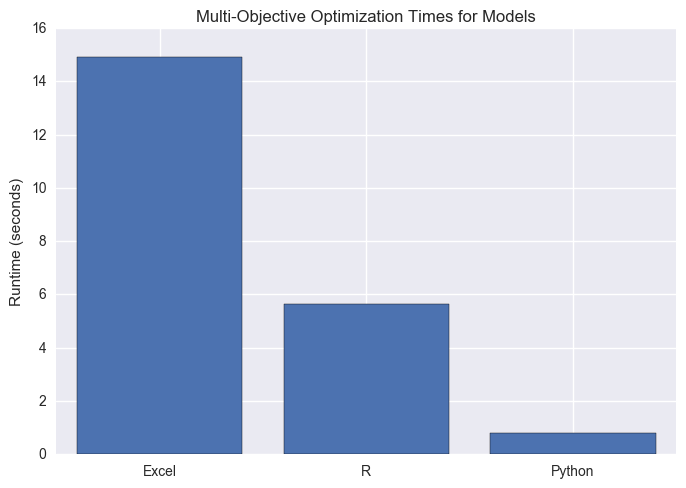

In [25]:
objects = ('Excel', 'R', 'Python')
y_pos = np.arange(len(objects))
performance = [runtime_xl, runtime_r, runtime_py]
 
plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Runtime (seconds)')
plt.title('Multi-Objective Optimization Times for Models')
 
plt.show()

It becomes clear that driving an Excel model from Rhodium comes at significant computational cost. As expected, the native Python model performed best.